In [1]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from scipy import optimize
import scipy.integrate as integrate
from scipy.interpolate import RBFInterpolator, InterpolatedUnivariateSpline
import scipy.special as special
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import h5py
import time
import tqdm
from typing import List, Tuple, Sequence

import os
os.chdir(os.getcwd())

In [61]:
N = 15       # number of loops
lc = 0.12     # magnetic core length / m
l = 7e-2
w = 18e-6 * 4
ur = 70000
u0 = 4* np.pi * 1e-7
u = ur * u0
Ac = l * w   # cross-sectional area / m2
fre = 4      # degauss frequency
T = 2       # deguass time
# R = 1 * 3.6 / 6  # resistance calculate
R = 1.55
gain = 15
samp_rate = 5000
n_sample = samp_rate * T

In [128]:
def get_data(fname,off_set):
    Vin = []
    Vpick = []
    for i in off_set:
        with h5py.File(fname, "a") as f:
            dset = f[f"{i}off"]
            Vin.append(dset[0])
            Vpick.append(dset[1])
    return np.array(Vin[0]),np.array(Vpick[0])

def get_general_data(fname,rname,off_set):
    Vin = []
    Vpick = []
    with h5py.File(fname, "a") as f:
        dset = f[rname]
        Vin.append(dset[0])
        Vpick.append(dset[1])
    return np.array(Vin[0]),np.array(Vpick[0])

def get_off(fname,runname = "off"):
    off_set = []
    off_get = []
    with h5py.File(fname, "a") as f:
        dset = f[runname]
        off_set.append(dset[0])
        off_get.append(dset[1])
    return np.array(off_set[0]), np.array(off_get[0])

def off_fit(off_set,off_get):
    coef = np.polyfit(off_set, off_get, 1)
    poly1d_fn = np.poly1d(coef) 
    return poly1d_fn

def test_func(x, a ,b, c):
    return a * np.sin(b * x + c)

def sin_fit(raw_data, Vset,time_stamp, fre, time_factor):
    # x_data = np.linspace(0 , 1/fre, len(raw_data))
    x_data = time_stamp
    y_data = raw_data
    params, params_covariance = optimize.curve_fit(test_func, x_data, y_data,p0=[0.5,time_factor*fre,0])
    plt.plot(x_data, y_data, '.', label='Data')
    plt.plot(x_data, test_func(x_data, params[0], params[1],params[2]),label='Fitted function',color = "r")
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
    return params, x_data

def off_subtract(Vin,Vpick,off_set,fitfun):
    input_off_fit = fitfun(off_set)/1000/3.6
    input_off_mea = np.mean(Vin[0:4000])
    print(input_off_mea)
    print(input_off_fit)
    Vin_sub = Vin - input_off_mea
    pick_off_mea = np.mean(Vpick[0:4000])
    Vpick_sub = Vpick - pick_off_mea
    return Vin_sub, Vpick_sub

In [95]:
file_name = "C:\\Users\\yuanhang.yang\\Documents\\GitHub\\new_cavity\\degauss_3_2_2024.hdf"
off_file_name = "off_set.hdf"
off = [0]
#Vpick, Vin = get_data(file_name,off)   # get both input voltage and pickup voltage
Vpick, Vin = get_general_data(file_name,"noamp10Vpp10Hz",off)
off_set, off_get = get_off(off_file_name)        # get offset calibration measured before
off_fit_fun = off_fit(off_set, off_get) 

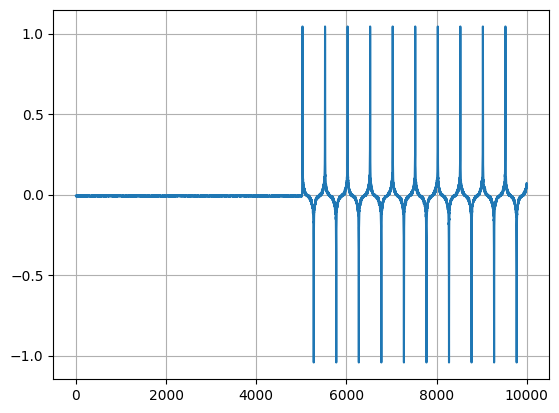

In [96]:
plt.plot(Vpick)
plt.grid(True)

In [97]:
time_stamp = np.linspace(0,T,len(Vin))

In [142]:
dt = 1/samp_rate
pos_peaks,_ = find_peaks(Vpick,distance=1000, height = max(Vpick)-0.2)
neg_peaks,_ = find_peaks(-Vpick,distance=1000, height = max(Vpick)-0.2)
print(pos_peaks[0:4])
print(neg_peaks[0:4])
print(neg_peaks[1] - pos_peaks[0])
print(pos_peaks[1] - neg_peaks[1])
time_used = time_stamp[pos_peaks[1]:-1]
Vin_used  = Vin[pos_peaks[1]:-1] 
Vpick_used = Vpick[pos_peaks[1]:-1]
Vin_mea, Vpick_mea = off_subtract(Vin_used,Vpick_used,off[0],off_fit_fun)
# Vin_mea = Vin_used
# Vpick_mea = Vpick_used
I = Vin_mea /R
H = np.array(I) * N / lc


[5525 6525 7525 8525]
[5773 6773 7773 8773]
1248
-248
-0.0016015968735728124
7.588888888888942e-05


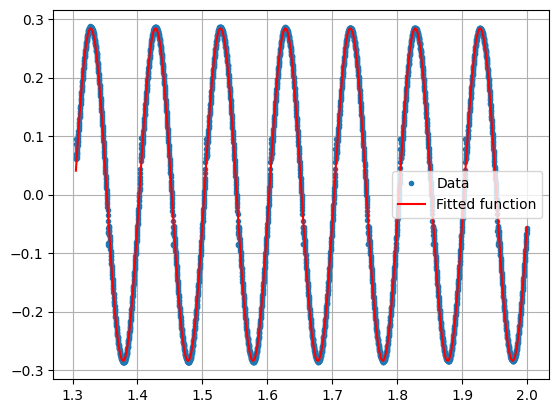

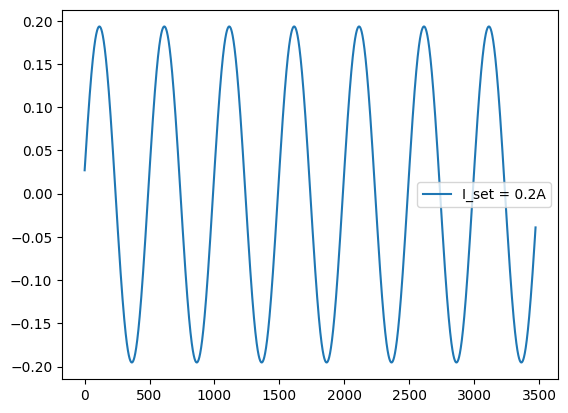

In [185]:
amp_fit = []
fre_fit = []
phase_fit = []
V_SGamp = []
Vamp = 10
param,x = sin_fit(Vin_mea,Vamp,time_used,10,6)
amp_fit.append(param[0])
fre_fit.append(param[1])
phase_fit.append(param[2])
if param[0] > 0:
    V_SGamp.append((2 * Vamp - 2*abs(param[0]))/2)
else:
    V_SGamp.append((-1* (2 * Vamp - 2*abs(param[0])))/2)

I = []
I_set = np.array(Vamp)/50

V_SG = test_func(x, V_SGamp, param[1],param[2])
I= (V_SG-0.05)/50
plt.plot(I, label  = "I_set = "+ str(I_set) + "A")
plt.legend()

The time between 1st positive peak & 1st negative peak is:  0.24962496249624944
The time between 1st negative peak & 2nd positive peak is:  -0.049604960496049566


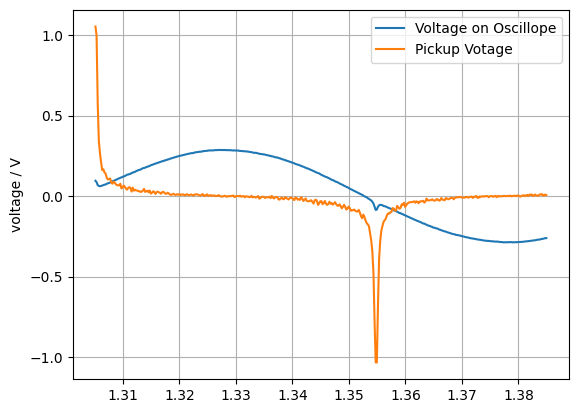

In [186]:
m = np.s_[0:400]
peak_num = 1
print("The time between 1st positive peak & 1st negative peak is: ", time_stamp[neg_peaks[peak_num]] - time_stamp[pos_peaks[peak_num-1]])
print("The time between 1st negative peak & 2nd positive peak is: ", time_stamp[pos_peaks[peak_num]] - time_stamp[neg_peaks[peak_num]])
plt.plot(time_used[m],Vin_mea[m], label =  "Voltage on Oscillope")
plt.plot(time_used[m],Vpick_mea[m], label =  "Pickup Votage")
plt.legend()
plt.ylabel("voltage / V")
plt.grid(True)

1.0540370012943687


IndexError: index 5525 is out of bounds for axis 0 with size 3474

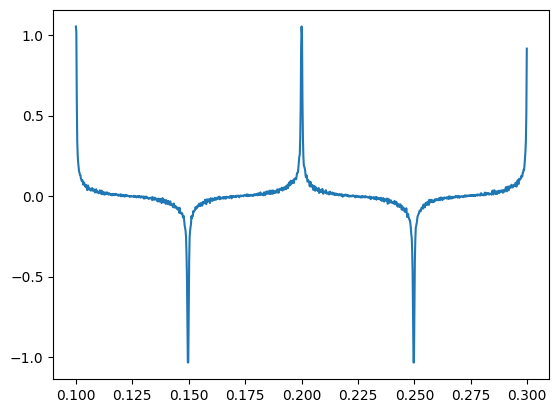

In [187]:
pos_peak_dis =( pos_peaks[1] - pos_peaks[0])
m = np.s_[pos_peak_dis-500:pos_peak_dis+500]
#plt.plot(time_stamp[m],I[m],label = "current")
plt.plot(time_stamp[m],Vpick_mea[m],label = "pickup voltage")
print(Vpick_mea[pos_peak_dis])
print("voltage difference between pos & neg peak:",Vpick_mea[pos_peaks[0]] + Vpick_mea[neg_peaks[0]] )
plt.ylabel("applied current or pickup voltage ")
plt.xlabel("time / s")
plt.title("measurement example")
plt.grid(True)
plt.legend()

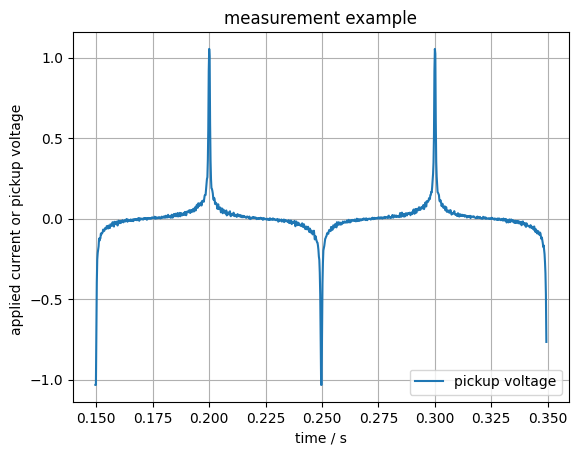

In [188]:
neg_peak_dis = neg_peaks[1] - pos_peaks[0]
m = np.s_[neg_peak_dis-500:neg_peak_dis+500]
#plt.plot(time_stamp[m],I[m],label = "current")
plt.plot(time_stamp[m],Vpick_mea[m],label = "pickup voltage")
plt.ylabel("applied current or pickup voltage ")
plt.xlabel("time / s")
plt.title("measurement example")
plt.grid(True)
plt.legend()

In [189]:
B = []
B_int = []
Bini = [0]
Vini = [0]
dB = np.array(Vpick_mea-0.0014)/Ac/N/gain
#print("magnetic field difference between pos & neg peak:",dB[pos_peaks[0]] + dB[neg_peaks[0]] )
print(len(dB))
H = np.array(I) * N / lc
for a in dB[0:-1]:
        Bini.append(Bini[-1] + (a)* dt )
B.append(Bini)

3474


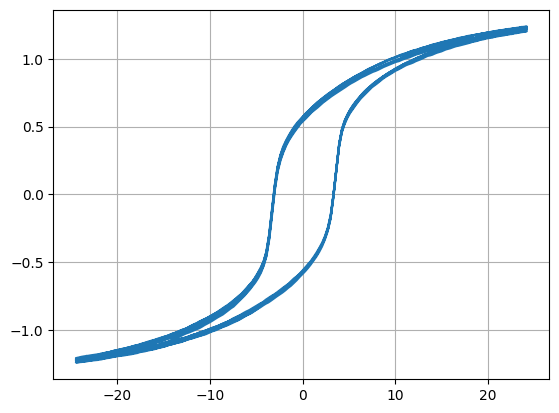

In [190]:
stop = 6000
m = np.s_[0:stop]
plt.plot(H[m],B[0][m]-(max(B[0])+min(B[0]))/2,"-")
plt.grid(True)

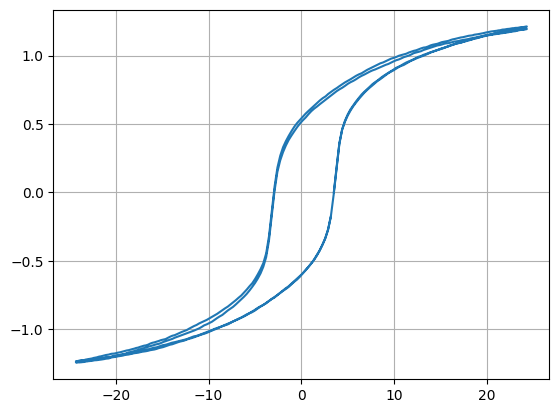

In [172]:
n = np.s_[00:1000]
plt.plot(H[n],B[0][n],"-")
plt.grid(True)

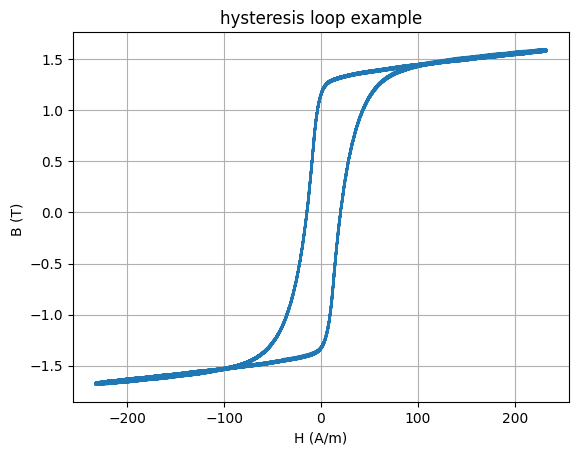

In [64]:
n = np.s_[-100000:-40000]
plt.plot(H[n],B[0][n]-(max(B[0])+min(B[0]))/2,"-")
plt.ylabel("B (T) ")
plt.xlabel("H (A/m)")
plt.title("hysteresis loop example")
plt.grid(True)

In [193]:
np.log(1/20)

-2.995732273553991